Name : Fahmida Akhter
OCS 4001 

Final Project 

In [24]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import random
import matplotlib.pyplot as plt
from scipy import stats

In [25]:
# Function to calculate Sea Level Rise (SLR) using the provided formula
def curve_function(t, a, b):
    return a * (t - 2005)**2 + b * (t - 2005)

# Function to calculate the present value of cost
def calculate_slr(t, x, y):
    return x * (t - 2005) ** 2 + y * (t - 2005)

# Function to calculate the present value of cost
def calculate_present_value_cost(cost, r, n):
    return cost * (1 + r) ** -n

# Function to calculate mitigated benefit
def calculate_mitigated_benefit(del_slr, loss_rate, carbon_stock, wetland_area, carbon_credit):
    mwll = (del_slr * loss_rate) / 100
    mce = mwll * carbon_stock / wetland_area
    mb = mce * carbon_credit
    return mwll, mce, mb

In [26]:
# Read the data from the .csv file
df = pd.read_csv('SLR.csv')

In [27]:
# Initialize lists to store scenario and BCR
scenario_list = [] # stores the list of random scenario it is choosing. 
bcr_list = []
cc_list=[]
dr_list=[]
rc_list=[]


# Number of iterations
iterations = 10000

# Loop for 100 times
for i in range(iterations):
    # Randomly select a scenario
    selected_scenario = random.choice(['0.3','0.5','1.0', '1.5', '2.0'])

    # Get the corresponding data for the selected scenario
    mean_column = f'{selected_scenario} - MED'
    low_column = f'{selected_scenario} - LOW'
    high_column = f'{selected_scenario} - HIGH'
    means = df[mean_column].values
    std_devs = (df[high_column].values - df[low_column].values) / 1.908  # Z-score for 87th percentile - Z-score for 13th percentile

    # Create DataFrame for mean and standard deviation
    df_stats = pd.DataFrame({'Year': df['Year'], 'Mean': means, 'Std Dev': std_devs})

In [28]:
# Create synthetic data points
synthetic_data = {}  # Initialize as a dictionary to store year and value pairs
for index, row in df_stats.iterrows():
    year = row['Year']  # Access the year
    mean = row['Mean']  # Access the mean
    std_dev = row['Std Dev']  # Access the standard deviation
    synthetic_data[year] = np.random.normal(loc=mean, scale=std_dev, size=1)[0]  # Generate one random point

# Create DataFrame for synthetic data
df_synthetic = pd.DataFrame({'Year': list(synthetic_data.keys()), 'Synthetic Value': list(synthetic_data.values())})

# Print the synthetic data
print(df_synthetic)

# Extract arrays for curve fitting
t_values = df_synthetic['Year'].values
y_values = df_synthetic['Synthetic Value'].values

      Year  Synthetic Value
0   2005.0         0.000000
1   2020.0        11.985891
2   2030.0        32.169764
3   2040.0        48.978869
4   2050.0        60.311579
5   2060.0        68.953551
6   2070.0        67.266166
7   2080.0        83.147972
8   2090.0       112.294439
9   2100.0       116.767300
10  2110.0       117.813998
11  2120.0       133.237856
12  2130.0       155.651112
13  2140.0       186.706025
14  2150.0       186.829848


In [29]:
# Fit the curve to the synthetic data points
try:
    popt, pcov = curve_fit(curve_function, t_values, y_values, p0=[1, 1])
    print(f"Curve fitting successful for {selected_scenario} scenario.")
    
    # Print the equation of the fitted curve
    equation = f"{selected_scenario} scenario: y = {popt[0]} * (t - 2005)**2 + {popt[1]} * (t - 2005)"
    print("Fitted Curve Equation:", equation)
    
    # Parameters for further calculations
    start_year = 2024
    end_year = 2100
    discount_rates = random.uniform(0.025, 0.07)
    carbon_credits = random.uniform(28.66, 340)

    print(f"Discount Rate: {discount_rates}")
    print(f"Carbon Credits: {carbon_credits}")
    
except Exception as e:
    print(f"Curve fitting failed for {selected_scenario} scenario: {e}")

Curve fitting successful for 0.5 scenario.
Fitted Curve Equation: 0.5 scenario: y = 0.0013895621239548017 * (t - 2005)**2 + 1.0889945858857946 * (t - 2005)
Discount Rate: 0.05763934711374684
Carbon Credits: 46.119282370119386


In [30]:
# Define missing parameters
per_ha_restoration_cost = random.uniform(500, 8250)
wetland_loss_rate = 47000
total_carbon_stock = 37000000
wetland_area = 133462

# Initialize other required variables
start_year = 2024
end_year = 2100
discount_rates = random.uniform(0.025, 0.07)

# Placeholder function for sea level rise calculation
def calculate_slr(year, a, b):
    return a * (year - 2005)**2 + b * (year - 2005)  # Example quadratic formula

# Placeholder for curve fitting parameters
popt = [0.01, 0.05]  # Replace with actual curve fitting results

# Create a DataFrame to store the results
columns = ["Year", "Sea Level Rise", "Delta SLR", "Cost", "Mitigated Wetland Loss", "Mitigated Carbon Emission",
           "Mitigated Benefit", "Mitigated Benefit (dis)", "Cumulative Cost", "Cumulative Mitigated Benefit (dis)"]
df_results = pd.DataFrame(columns=columns)

# Initialize cumulative variables
cumulative_cost = 0
cumulative_mitigated_benefit = 0

# Calculate and store values for each year
for year in range(start_year, end_year + 1):
    n = year - start_year

    # Calculate Sea Level Rise
    slr = calculate_slr(year, popt[0], popt[1])

    # Calculate Delta SLR (difference between consecutive years)
    del_slr = slr - calculate_slr(year - 1, popt[0], popt[1]) if year > start_year else 0

    # Calculate present value of cost
    cost = wetland_area * per_ha_restoration_cost * ((1 + discount_rates) ** (-n))

    cumulative_cost += cost  # Add current year's cost to cumulative cost

    # Update DataFrame
    df_results = pd.concat([df_results, pd.DataFrame([{
        "Year": year,
        "Sea Level Rise": slr,
        "Delta SLR": del_slr,
        "Cost": cost,
        "Mitigated Wetland Loss": 0,  # Placeholder
        "Mitigated Carbon Emission": 0,  # Placeholder
        "Mitigated Benefit": 0,  # Placeholder
        "Mitigated Benefit (dis)": 0,  # Placeholder
        "Cumulative Cost": cumulative_cost,
        "Cumulative Mitigated Benefit (dis)": cumulative_mitigated_benefit,
    }])])

# View the resulting DataFrame
print(df_results)

    Year  Sea Level Rise Delta SLR          Cost Mitigated Wetland Loss  \
0   2024            4.56         0  2.067531e+08                      0   
0   2025            5.00      0.44  2.005040e+08                      0   
0   2026            5.46      0.46  1.944438e+08                      0   
0   2027            5.94      0.48  1.885667e+08                      0   
0   2028            6.44       0.5  1.828672e+08                      0   
..   ...             ...       ...           ...                    ...   
0   2096           87.36      1.86  2.268607e+07                      0   
0   2097           89.24      1.88  2.200038e+07                      0   
0   2098           91.14       1.9  2.133542e+07                      0   
0   2099           93.06      1.92  2.069055e+07                      0   
0   2100           95.00      1.94  2.006518e+07                      0   

   Mitigated Carbon Emission Mitigated Benefit Mitigated Benefit (dis)  \
0                        

C:\Users\fahmi\AppData\Local\Temp\ipykernel_16908\2052963453.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([{


In [32]:
import pandas as pd
import numpy as np

# Function to calculate Delta SLR (Sea Level Rise) based on the year
def calculate_delta_slr(year):
    # Example logic: Adjust this with your actual calculation
    return 0.1 * year  # Replace with meaningful calculation logic

# Example function definitions for the other calculations
def calculate_wetland_parameters(year):
    # Placeholder logic for wetland parameters
    wetland_loss_rate = 0.05 * year  # Example calculation
    total_carbon_stock = 1000 * year  # Example calculation
    wetland_area = 50 * year  # Example calculation
    return wetland_loss_rate, total_carbon_stock, wetland_area

def calculate_cost(year):
    # Placeholder logic for cost calculation
    return 1000 * year  # Example cost calculation

def calculate_mitigated_benefit(del_slr, wetland_loss_rate, total_carbon_stock, wetland_area, carbon_credits):
    # Example placeholder logic
    mwll = del_slr * wetland_loss_rate
    mce = del_slr * total_carbon_stock
    mb = mwll + mce
    return mwll, mce, mb

def calculate_present_value_cost(mb, discount_rates, n):
    # Example calculation for present value cost
    return mb / (1 + discount_rates) ** n

# Initialize variables
start_year = 2000
end_year = 2100
discount_rates = 0.05  # Example discount rate
n = 1  # Example period
selected_scenario = "Scenario 1"  # Example scenario
carbon_credits = 100  # Example carbon credits
per_ha_restoration_cost = 2000  # Example restoration cost per hectare

# Initialize empty lists for storing results
scenario_list = []
dr_list = []
cc_list = []
rc_list = []
bcr_list = []

# Initialize an empty DataFrame for results
df_results = pd.DataFrame(columns=["Year", "Sea Level Rise", "Delta SLR", "Cost", "Mitigated Wetland Loss",
                                   "Mitigated Carbon Emission", "Mitigated Benefit", "Mitigated Benefit (dis)",
                                   "Cumulative Cost", "Cumulative Mitigated Benefit (dis)"])

cumulative_cost = 0
cumulative_mitigated_benefit = 0

# Loop over years or scenarios (loop logic assumed here)
for year in range(start_year, end_year + 1):
    try:
        # Calculate sea level rise and parameters
        del_slr = calculate_delta_slr(year)  # Calculate Delta SLR based on the year
        wetland_loss_rate, total_carbon_stock, wetland_area = calculate_wetland_parameters(year)
        cost = calculate_cost(year)

        # Calculate mitigated benefit for each discount rate
        mwll, mce, mb = calculate_mitigated_benefit(del_slr, wetland_loss_rate, total_carbon_stock, wetland_area,
                                                     carbon_credits)
        mb_percent = calculate_present_value_cost(mb, discount_rates, n)

        cumulative_mitigated_benefit += mb_percent  # Add current year's mitigated benefit to cumulative mitigated benefit

        # Append the results to the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({"Year": [year], "Sea Level Rise": [del_slr], "Delta SLR": [del_slr], 
                                                           "Cost": [cost], "Mitigated Wetland Loss": [mwll], 
                                                           "Mitigated Carbon Emission": [mce], "Mitigated Benefit": [mb], 
                                                           "Mitigated Benefit (dis)": [mb_percent], 
                                                           "Cumulative Cost": [cumulative_cost], 
                                                           "Cumulative Mitigated Benefit (dis)": [cumulative_mitigated_benefit]})],
                               ignore_index=True)

        # Calculate and print BCR at year 2100
        if year == end_year:
            bcr = cumulative_mitigated_benefit / cumulative_cost
            print(f"Benefit-Cost Ratio (BCR) at year 2100: {bcr}")
            bcr_list.append(bcr)  # Store the calculated BCR for the scenario
            scenario_list.append(selected_scenario)  # Store the selected scenario
            cc_list.append(carbon_credits)
            dr_list.append(discount_rates)
            rc_list.append(per_ha_restoration_cost)

    except ValueError as e:
        print(f"Error for {selected_scenario} scenario with error:", e)

# Save the results DataFrame to a CSV file
result_df = pd.DataFrame({'Scenario': scenario_list, 'dr': dr_list, 'cc': cc_list, 'rc': rc_list, 'BCR': bcr_list})

# Export the DataFrame to a CSV file
result_df.to_csv('scenario_bcr_results_10000_2100.csv', index=False)

   

C:\Users\fahmi\AppData\Local\Temp\ipykernel_16908\4052757369.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame({"Year": [year], "Sea Level Rise": [del_slr], "Delta SLR": [del_slr],


ZeroDivisionError: float division by zero

In [33]:
import pandas as pd
import numpy as np

# Function to calculate Delta SLR (Sea Level Rise) based on the year
def calculate_delta_slr(year):
    # Example logic: Adjust this with your actual calculation
    return 0.1 * year  # Replace with meaningful calculation logic

# Example function definitions for the other calculations
def calculate_wetland_parameters(year):
    # Placeholder logic for wetland parameters
    wetland_loss_rate = 0.05 * year  # Example calculation
    total_carbon_stock = 1000 * year  # Example calculation
    wetland_area = 50 * year  # Example calculation
    return wetland_loss_rate, total_carbon_stock, wetland_area

def calculate_cost(year):
    # Placeholder logic for cost calculation
    return 1000 * year  # Example cost calculation

def calculate_mitigated_benefit(del_slr, wetland_loss_rate, total_carbon_stock, wetland_area, carbon_credits):
    # Example placeholder logic
    mwll = del_slr * wetland_loss_rate
    mce = del_slr * total_carbon_stock
    mb = mwll + mce
    return mwll, mce, mb

def calculate_present_value_cost(mb, discount_rates, n):
    # Example calculation for present value cost
    return mb / (1 + discount_rates) ** n

# Initialize variables
start_year = 2000
end_year = 2100
discount_rates = 0.05  # Example discount rate
n = 1  # Example period
selected_scenario = "Scenario 1"  # Example scenario
carbon_credits = 100  # Example carbon credits
per_ha_restoration_cost = 2000  # Example restoration cost per hectare

# Initialize empty lists for storing results
scenario_list = []
dr_list = []
cc_list = []
rc_list = []
bcr_list = []

# Initialize an empty DataFrame for results
df_results = pd.DataFrame(columns=["Year", "Sea Level Rise", "Delta SLR", "Cost", "Mitigated Wetland Loss",
                                   "Mitigated Carbon Emission", "Mitigated Benefit", "Mitigated Benefit (dis)",
                                   "Cumulative Cost", "Cumulative Mitigated Benefit (dis)"])

# Initialize cumulative variables
cumulative_cost = 0
cumulative_mitigated_benefit = 0

# Loop over years or scenarios (loop logic assumed here)
for year in range(start_year, end_year + 1):
    try:
        # Calculate sea level rise and parameters
        del_slr = calculate_delta_slr(year)  # Calculate Delta SLR based on the year
        wetland_loss_rate, total_carbon_stock, wetland_area = calculate_wetland_parameters(year)
        cost = calculate_cost(year)

        # Calculate mitigated benefit for each discount rate
        mwll, mce, mb = calculate_mitigated_benefit(del_slr, wetland_loss_rate, total_carbon_stock, wetland_area, carbon_credits)
        mb_percent = calculate_present_value_cost(mb, discount_rates, n)

        # Update cumulative values
        cumulative_mitigated_benefit += mb_percent  # Add current year's mitigated benefit to cumulative mitigated benefit
        cumulative_cost += cost  # Add current year's cost to cumulative cost

        # Append the results to the DataFrame
        new_data = pd.DataFrame({"Year": [year], "Sea Level Rise": [del_slr], "Delta SLR": [del_slr],
                                 "Cost": [cost], "Mitigated Wetland Loss": [mwll], "Mitigated Carbon Emission": [mce],
                                 "Mitigated Benefit": [mb], "Mitigated Benefit (dis)": [mb_percent],
                                 "Cumulative Cost": [cumulative_cost], "Cumulative Mitigated Benefit (dis)": [cumulative_mitigated_benefit]})

        # Remove columns with all NaN values before concatenation
        new_data = new_data.dropna(axis=1, how='all')

        # Only append if the new_data contains non-NA values
        if not new_data.isnull().values.all():
            df_results = pd.concat([df_results, new_data], ignore_index=True)

        # Calculate and print BCR at year 2100
        if year == end_year:
            if cumulative_cost > 0:  # Avoid division by zero
                bcr = cumulative_mitigated_benefit / cumulative_cost
                print(f"Benefit-Cost Ratio (BCR) at year 2100: {bcr}")
                bcr_list.append(bcr)  # Store the calculated BCR for the scenario
                scenario_list.append(selected_scenario)  # Store the selected scenario
                cc_list.append(carbon_credits)
                dr_list.append(discount_rates)
                rc_list.append(per_ha_restoration_cost)
            else:
                print("Cumulative cost is zero at year 2100, BCR cannot be calculated.")

    except ValueError as e:
        print(f"Error for {selected_scenario} scenario with error:", e)

# Create a final result DataFrame to store BCR and other results
result_df = pd.DataFrame({'Scenario': scenario_list, 'dr': dr_list, 'cc': cc_list, 'rc': rc_list, 'BCR': bcr_list})

# Export the DataFrame to a CSV file
result_df.to_csv('t1scenario_bcr_results_10000_2100.csv', index=False)

C:\Users\fahmi\AppData\Local\Temp\ipykernel_16908\3464789607.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, new_data], ignore_index=True)


Benefit-Cost Ratio (BCR) at year 2100: 195.2873480836237


In [23]:
# Initialize cumulative variables before the loop
cumulative_cost = 0  # Initialize cumulative_cost
cumulative_mitigated_benefit = 0  # Initialize cumulative_mitigated_benefit

# Loop over years or scenarios (loop logic assumed here)
for year in range(start_year, end_year + 1):
    try:
        # Replace with actual calculations
        del_slr = calculate_delta_slr(year)  # Assuming this function is defined
        wetland_loss_rate, total_carbon_stock, wetland_area = calculate_wetland_parameters(year)
        cost = calculate_cost(year)
        
        # Calculate mitigated benefit for each discount rate
        mwll, mce, mb = calculate_mitigated_benefit(del_slr, wetland_loss_rate, total_carbon_stock, wetland_area, carbon_credits)
        mb_percent = calculate_present_value_cost(mb, discount_rates, n)

        cumulative_mitigated_benefit += mb_percent  # Add current year's mitigated benefit to cumulative mitigated benefit
        cumulative_cost += cost  # Add current year's cost to cumulative cost

        # Append the results to the DataFrame
        new_data = pd.DataFrame({"Year": [year], "Sea Level Rise": [del_slr], "Delta SLR": [del_slr], "Cost": [cost],
                                 "Mitigated Wetland Loss": [mwll], "Mitigated Carbon Emission": [mce],
                                 "Mitigated Benefit": [mb], "Mitigated Benefit (dis)": [mb_percent],
                                 "Cumulative Cost": [cumulative_cost],
                                 "Cumulative Mitigated Benefit (dis)": [cumulative_mitigated_benefit]})

        # Remove columns with all NaN values before concatenation
        new_data = new_data.dropna(axis=1, how='all')

        # Only append if the new_data contains non-NA values
        if not new_data.isnull().values.all():
            df_results = pd.concat([df_results, new_data], ignore_index=True)

        # Calculate and print BCR at year 2100
        if year == end_year:
            if cumulative_cost > 0:  # Avoid division by zero
                bcr = cumulative_mitigated_benefit / cumulative_cost
                print(f"Benefit-Cost Ratio (BCR) at year 2100: {bcr}")
                bcr_list.append(bcr)  # Store the calculated BCR for the scenario
                scenario_list.append(selected_scenario)  # Store the selected scenario
                cc_list.append(carbon_credits)
                dr_list.append(discount_rates)
                rc_list.append(per_ha_restoration_cost)
            else:
                print("Cumulative cost is zero at year 2100, BCR cannot be calculated.")

    except ValueError as e:
        print(f"Curve fitting failed for {selected_scenario} scenario with error:", e)

# Create a final result DataFrame to store BCR and other results
result_df = pd.DataFrame({'Scenario': scenario_list, 'dr': dr_list, 'cc': cc_list, 'rc': rc_list, 'BCR': bcr_list})

# Export the DataFrame to a CSV file
result_df.to_csv('fscenario_bcr_results_10000_2100.csv', index=False)

# Optional: Save the full results DataFrame to Excel (if desired)
# df_results.to_excel(f"mitigation_results_{selected_scenario}_iteration_{i+1}.xlsx", index=False)

Benefit-Cost Ratio (BCR) at year 2100: 195.2873480836237


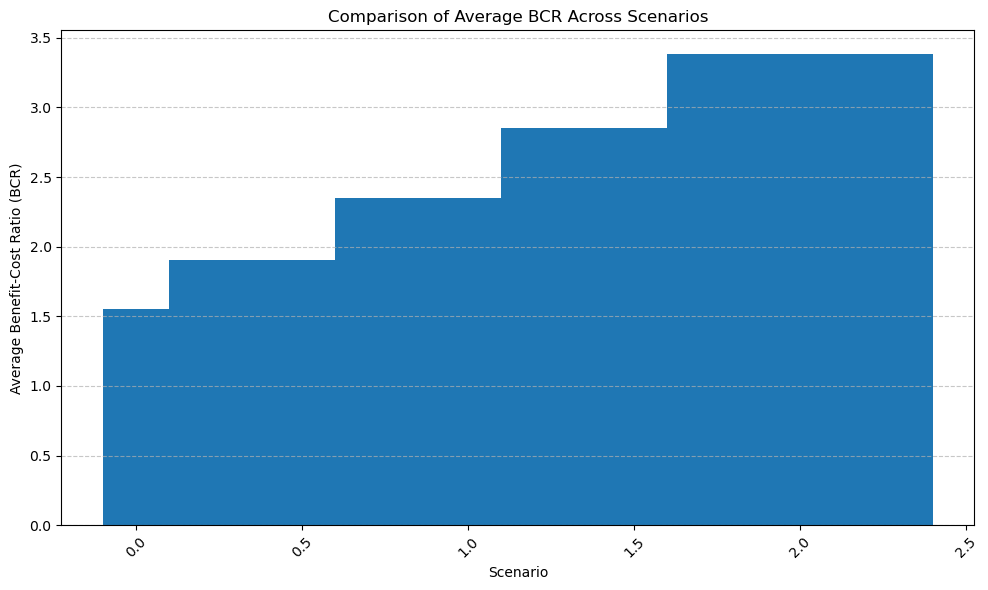

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('scenario_bcr_results_10000_2100.csv')

# Group by 'Scenario' and calculate mean BCR for each scenario
bcr_by_scenario = data.groupby('Scenario')['BCR'].mean().reset_index()

# Sort the scenarios for better visualization
bcr_by_scenario = bcr_by_scenario.sort_values(by='BCR', ascending=False)

# Plotting the comparison of BCR across different scenarios
plt.figure(figsize=(10, 6))
plt.bar(bcr_by_scenario['Scenario'], bcr_by_scenario['BCR'])
plt.xlabel('Scenario')
plt.ylabel('Average Benefit-Cost Ratio (BCR)')
plt.title('Comparison of Average BCR Across Scenarios')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

In [46]:
# Define the output folder and filename
output_path = 'histograms_dr_cc_rc.png'  # Replace with full path if needed, e.g., '/path/to/folder/filename.png'

# Plot histograms for 'dr', 'cc', and 'rc' columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for 'dr'
axes[0].hist(data['dr'], bins=30, edgecolor='k', alpha=0.7)
axes[0].set_title('Histogram of Discount Rate (dr)')
axes[0].set_xlabel('Discount Rate')
axes[0].set_ylabel('Frequency')

# Histogram for 'cc'
axes[1].hist(data['cc'], bins=30, edgecolor='k', alpha=0.7)
axes[1].set_title('Histogram of Sea Level Rise (cc)')
axes[1].set_xlabel('Sea Level Rise')
axes[1].set_ylabel('Frequency')

# Histogram for 'rc'
axes[2].hist(data['rc'], bins=30, edgecolor='k', alpha=0.7)
axes[2].set_title('Histogram of Restoration Cost (rc)')
axes[2].set_xlabel('Restoration Cost')
axes[2].set_ylabel('Frequency')

# Layout adjustment
plt.tight_layout()

# Save the figure to the folder
plt.savefig(output_path, dpi=300)  # Save with 300 DPI for high quality
plt.close()

print(f"Figure saved as {output_path}")

Figure saved as histograms_dr_cc_rc.png


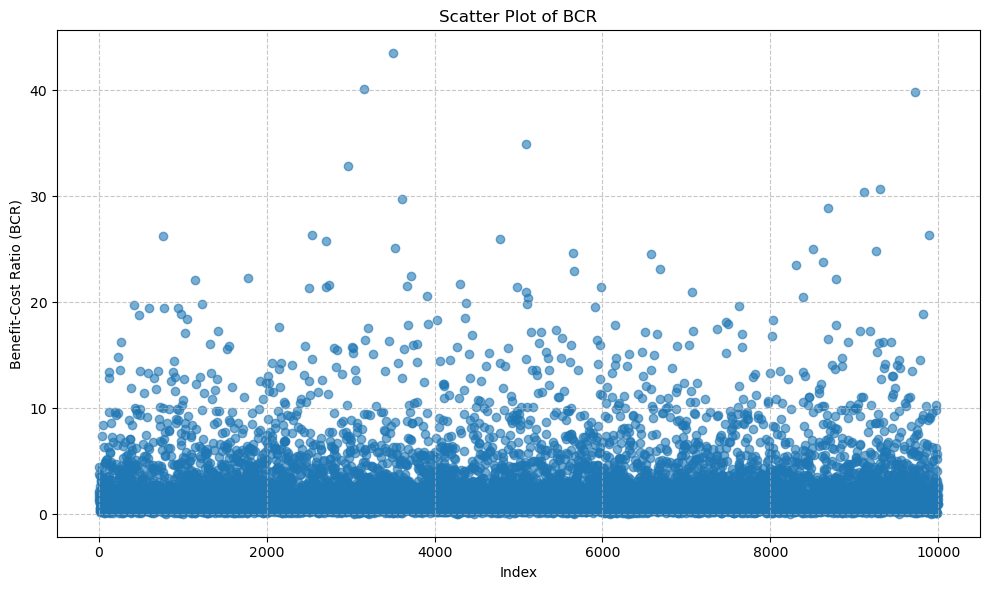

<Figure size 640x480 with 0 Axes>

In [47]:
# Scatter plot of BCR
plt.figure(figsize=(10, 6))
plt.scatter(range(len(data)), data['BCR'], alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Benefit-Cost Ratio (BCR)')
plt.title('Scatter Plot of BCR')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

plt.savefig('C:/Users/fahmi/OneDrive - Louisiana State University/Fall 2024/OCS 4001/2100/scatter_plot_bcr.png', dpi=300) 